# Forest Cover Prediction
## by: Avengers End Game
### authors: Naga Chandrasekaran, Scott Gatzemeier, Aidan Jackson, and Andi Morey Peterson 

### Executive Summary

The goal of this project is to classify trees in four different wilderness areas of the Roosevelt National Forest in Northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.  Accurate results of a successful model will allow US Forest Service (USFS) to predict the predominant cover type trees to plant in reforestation efforts of the 800,000 acres in the Roosevelt National Forest.


<figure class="image">
  <img src="https://i.ytimg.com/vi/Yi4ICw5L4h0/maxresdefault.jpg" width="450" height="500" align="center" />
  <figcaption class="figure-caption text-center"> https://alchetron.com/Roosevelt-National-Forest </figcaption>
</figure>


The data was collected by the USFS and the US Geological Survey and provided to Kaggle by Colorado State University.  Each entry of the dataset represents a 30x30 meter cell.  The project will attempt to predict one of seven cover types using features such as elevation, slope, soil type, wilderness areas, aspect, and distance measures.

<a id='Home'></a>

#### Table of Contents:

1) <a href='#Exploratory_Data_Analysis'>Exploratory Data Analysis</a>

2) <a href='#Initial_Machine_Learning_Models'>Initial Machine Learning Models</a> 

3) <a href='#Feature_Engineering'>Feature Engineering</a> 

4) <a href='#Hyperparameter_Tuning'>Hyperparameter Tuning</a> 

5) <a href='#Evaluation_of_the_Best_Model'>Evaluatation the Best Model</a> 

6) <a href='#Interpret_Model_Results'>Interpret Model Results</a> 

7) <a href='#Summary_Conclusions'>Summary and Conclusions</a> 

8) <a href='#References'>References</a> 


<a id='Exploratory_Data_Analysis'></a>
## 1. Exploratory Data Analysis

### 1.1 Read in Data

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from scipy.stats import mode


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

np.random.seed(0)

raw_data = pd.read_csv(r"data/covtype.csv") #https://www.kaggle.com/uciml/forest-cover-type-dataset
train_df = pd.read_csv(r"data/train.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data
test_df = pd.read_csv(r"data/test.csv") #https://www.kaggle.com/c/forest-cover-type-prediction/data

*Note on data sourcing*:  The data used for this project comes from Kaggle. The ["Raw" Data Set](https://www.kaggle.com/uciml/forest-cover-type-dataset) consists of both the train and test data sets and is labeled, however does not have ID's in which to identify each entry.  For the purposes of this project, the raw dataset will only be used for EDA but not used in model building. The train and test datasets [(found here)](https://www.kaggle.com/c/forest-cover-type-prediction/data) are used as such in all future models.

### 1.2 Shape and Features

In [2]:
#Print out Shape and features of the data
print('Data Dimensions for Raw Data:')
print('   Number of Records:', raw_data.shape[0])
print('   Number of Features:', raw_data.shape[1])
print('Data Dimensions for Train Data:')
print('   Number of Records:', train_df.shape[0])
print('   Number of Features:', train_df.shape[1])
print('Data Dimensions for Test Data:')
print('   Number of Records:', test_df.shape[0])
print('   Number of Features:', test_df.shape[1])
print('Feature Names:')
print(raw_data.columns)

Data Dimensions for Raw Data:
   Number of Records: 581012
   Number of Features: 55
Data Dimensions for Train Data:
   Number of Records: 15120
   Number of Features: 56
Data Dimensions for Test Data:
   Number of Records: 565892
   Number of Features: 55
Feature Names:
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Ty

### 1.3 Class and Feature Information:

#### Class Information
The seven cover types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

First, the distribution will tell if there is skewness in the predictions we are trying to replicate.

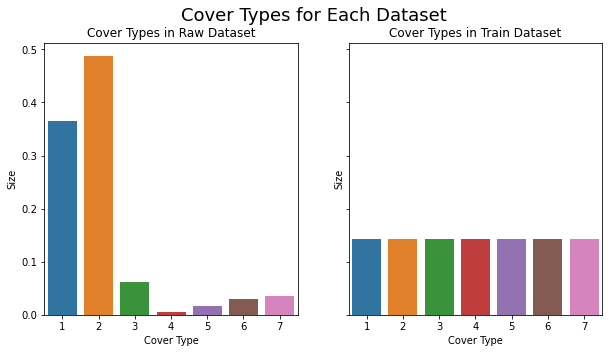

In [3]:
#Plot distribution of cover types
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

ax[0].set(ylabel='Percentage of Data')

class_dist=raw_data.groupby('Cover_Type').size()/raw_data.shape[0]
class_label=pd.DataFrame(class_dist,columns=['Size'])
sns.barplot(ax=ax[0],x=class_label.index,y='Size',data=class_label)
ax[0].set_title("Cover Types in Raw Dataset")
ax[0].set(xlabel='Cover Type')

class_dist=train_df.groupby('Cover_Type').size()/train_df.shape[0]
class_label=pd.DataFrame(class_dist,columns=['Size'])
sns.barplot(ax=ax[1],x=class_label.index,y='Size',data=class_label)
ax[1].set_title("Cover Types in Train Dataset")
ax[1].set(xlabel='Cover Type')

plt.suptitle('Cover Types for Each Dataset', fontsize=18)
plt.show()

The training data set that we will use for the model building is evenly distributed, but the raw dataset is very biased towards the first two cover types. This will strongly impact the evaluation results on the test set and will need to be taken into consideration in model building.

#### Feature Information:

The rest of the data that we can use as features for models are as follows:

- Elevation (continuous) - Elevation in meters
- Aspect (continuous) - Aspect in degrees azimuth
- Slope (continuous) - Slope in degrees
- Horizontal_Distance_To_Hydrology (continuous) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (continuous) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (continuous) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
    - Hillshade columns are the RGB color representation of the shadow at a particular time so the range is fixed between 0 and 255.
- Horizontal_Distance_To_Fire_Points (continuous) - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
    - Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value.
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

**Source:**: https://archive.ics.uci.edu/ml/datasets/covertype

First, let's take a look at our continuous data.

In the training and test dataset, the first 10 features of each observation (Elevation to Horizontal_Distance_To_Fire_Points) are continuous, with different ranges. The remaining 44 features are all binary. 4 of those 44 binary features correspond to Wilderness Area (i.e., there are 4 possible types), so any observation will have one 1 and three 0's in those columns. The last 40 features correspond to Soil Type (i.e., there are 40 possible types), so any observation will have one 1 and thirty-nine 0's in those columns.

### 1.4 Histograms

/Users/aidanjackson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aidanjackson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aidanjackson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

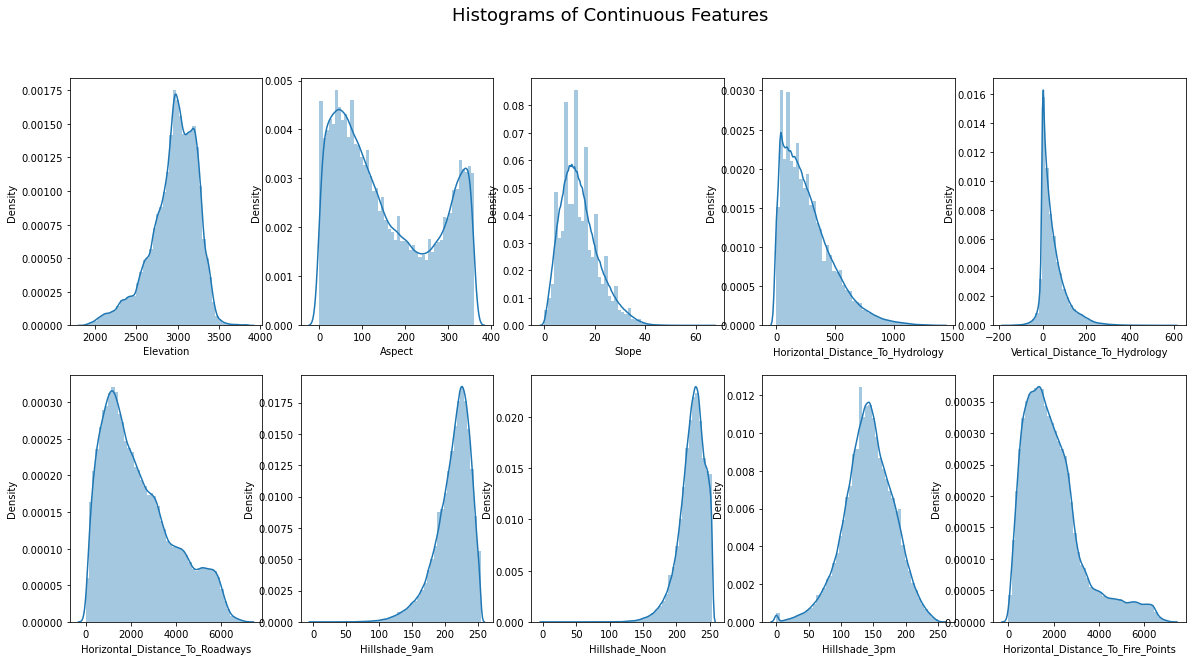

In [4]:
#plot the continuous data
fig, ax = plt.subplots(2, 5, figsize=(20,10))
continuous_data=raw_data.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']

for i, col in enumerate(continuous_data.columns):
    sns.distplot(ax=ax[int(i/5),i%5],a=continuous_data[col])
    
plt.suptitle('Histograms of Continuous Features', fontsize=18)
plt.show()

The histograms of each feature in the training data set indicates a non-normal distribution for most of the variables. Hillshade 3-m and slope show a near normal distribution. We noticed that the histogram of Hillshade_3pm contains several 0's, especially in the training set, which might make us think of missing values coded with 0, but according to the dataset description that feature can take this value, so we shall accept those values as valid. Wilderness area variable is a binary attribute with 0 or 1 for the values. Test data set distribution shown below is very similar to the training dataset distribution with the exception of Elevation and Slope attributes, which show a different distribution for test dataset.

### 1.5 Aspect Polar Plot

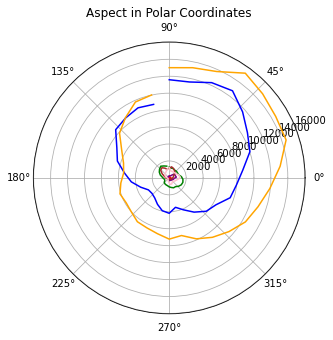

In [5]:
plt.figure(figsize=(15,5))
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 1)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 1)]["Aspect"], bins=30)[0][0:30], c='blue')
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 2)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 2)]["Aspect"], bins=30)[0][0:30], c='orange')
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 3)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 3)]["Aspect"], bins=30)[0][0:30], c='green')
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 4)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 4)]["Aspect"], bins=30)[0][0:30], c='red')
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 5)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 5)]["Aspect"], bins=30)[0][0:30], c='purple')
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 6)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 6)]["Aspect"], bins=30)[0][0:30], c='brown')
plt.polar((90-(np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 7)]["Aspect"], bins=30)[1][0:30]))*np.pi/180,
               np.histogram(raw_data.loc[(raw_data['Cover_Type'] == 7)]["Aspect"], bins=30)[0][0:30], c='pink')
plt.title("Aspect in Polar Coordinates")
plt.show()


<img src="https://www.researchgate.net/profile/Jeffrey-Skousen/publication/319127915/figure/fig20/AS:614046248218627@1523411442593/3-Diagram-showing-tree-growth-potential-based-on-the-direction-that-a-slope-faces.png" width="350" height="350" align="left" />

   The aspect describes which direction on the mountain area the tree grows.  This chart maches that of the aspect chart for tree growth potential by the USFS.  In this particular diagram, the cover type may be influnced by the slope face (aspect) due to its influence on availablity of soil moisture and sunlight. <sup>\[1\]</sup> 

### 1.6 Violin Plots of Key Continuous Features

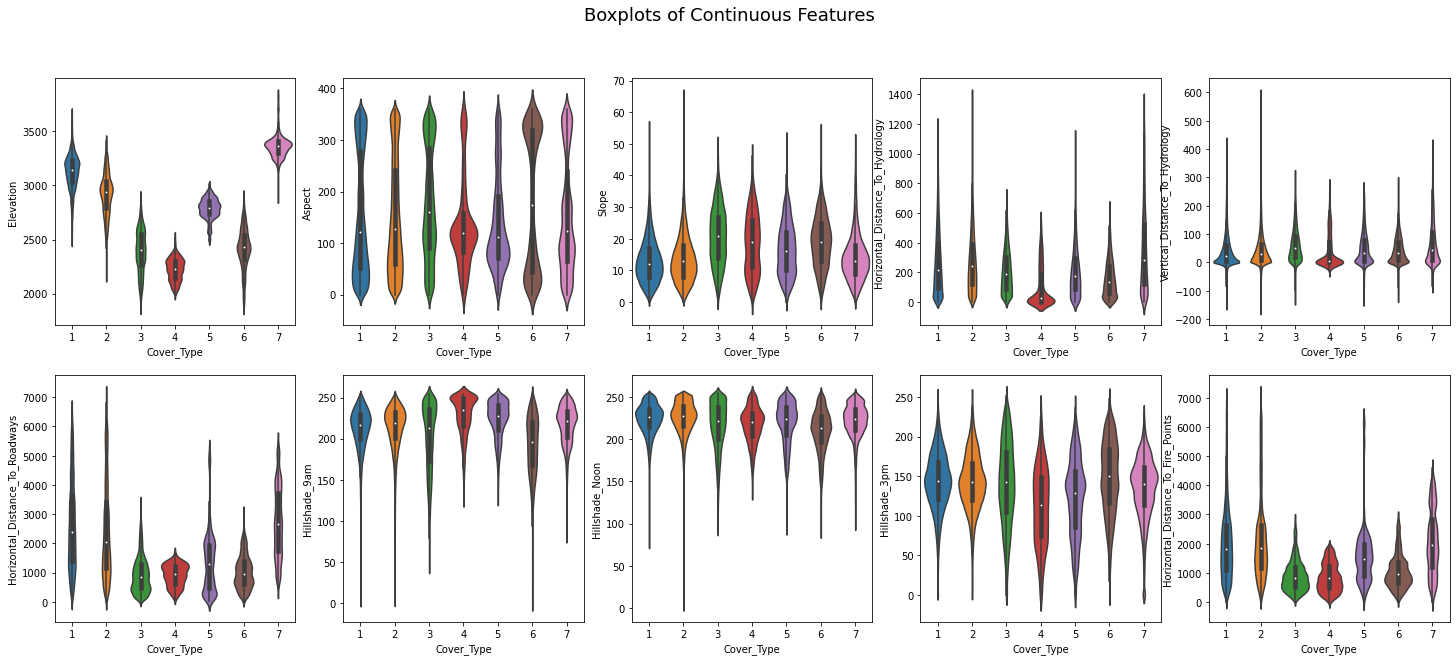

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
raw_data['Cover_Type']=raw_data['Cover_Type'].astype('category') #To convert target class into category
for i, col in enumerate(continuous_data.columns):
    #sns.boxplot(ax=ax[int(i/5),i%5], x=raw_data['Cover_Type'], y=col, data=raw_data)
    sns.violinplot(ax=ax[int(i/5),i%5], x=raw_data['Cover_Type'], y=col, data=raw_data)
    
plt.suptitle('Boxplots of Continuous Features', fontsize=18)
plt.show()

When we review different continuous variables as a function of the cover type, we can observe that elevation has the most dependence on cover type. We can see from the aboe box plots that cover type varies by elevation more while the box plots for aspect, slope, horizontal distance and other contiuous variables do not show any strong impact on cover type. While we observe some outiers, we do not see dependence of cover type on most continuous variables (except elevation).


### 1.7 Skewness

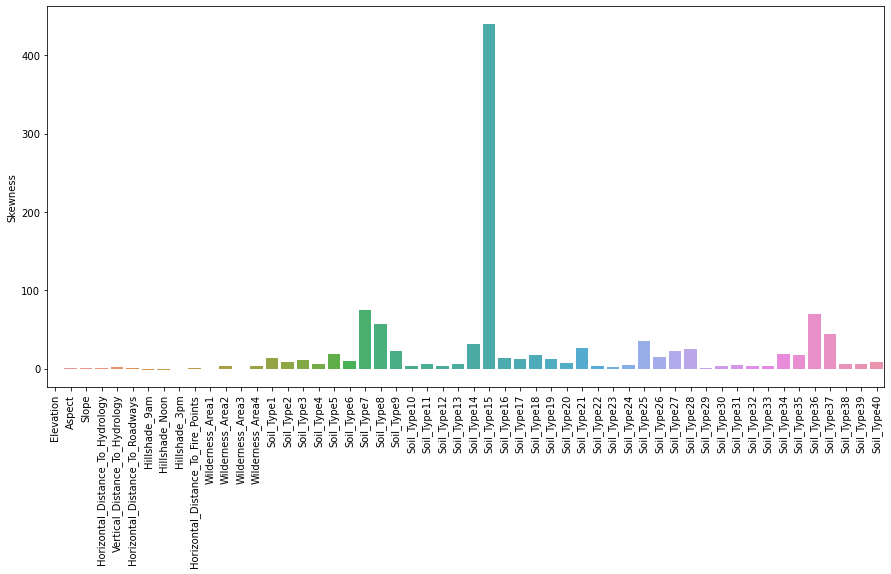

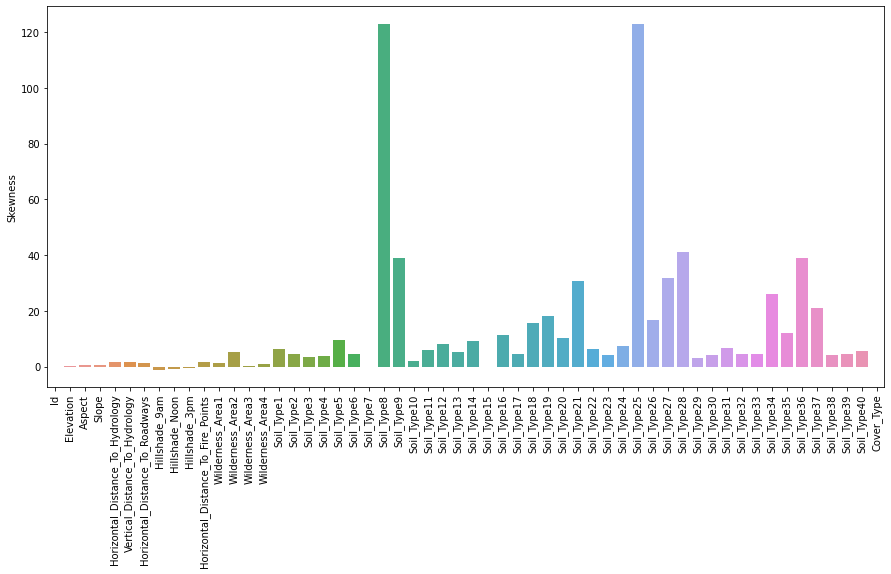

In [7]:
# Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable 
# about its mean. Let us run skew to find the skewness in our data
skew=raw_data.skew()
skew_df=pd.DataFrame(skew,index=None,columns=['Skewness'])
plt.figure(figsize=(15,7))
sns.barplot(x=skew_df.index,y='Skewness',data=skew_df)
plt.xticks(rotation=90)
plt.show()


# Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable 
# about its mean. Let us run skew to find the skewness in our data
skew=train_df.skew()
skew_df=pd.DataFrame(skew,index=None,columns=['Skewness'])
plt.figure(figsize=(15,7))
sns.barplot(x=skew_df.index,y='Skewness',data=skew_df)
plt.xticks(rotation=90)
plt.show()

We can observe high skewness in few soil types in the both the raw and train data sets. Based on these observations, we might have to perform some transformation to account for this skewness.

Now that we've done EDA on the continuous variables and noticed the skewness of the binary variables (Soil Type and Wilderness Areas), let us investigate those binary features further.

### 1.8 Density Plots of Wilderness Areas and Soil Types

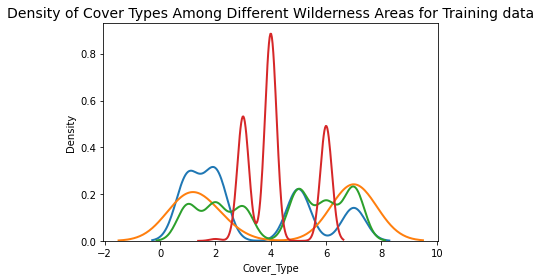

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

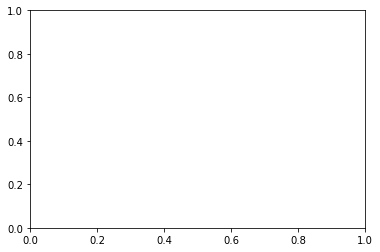

In [8]:
# Check if the Cover_Type shows non-uniform distribution among different Wilderness_Areas
# Create one column as Wilderness_Area_Type and represent it as categorical data

data = train_df.copy()
data['Wilderness_Area_Type'] = (data.iloc[:, 11:15] == 1).idxmax(1)

#list of wilderness areas
wilderness_areas = sorted(data['Wilderness_Area_Type'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
figsize=(14,10)

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = data[data['Wilderness_Area_Type'] == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_Type")
plt.title("Density of Cover Types Among Different Wilderness Areas for Training data", size=14)
plt.show()


data = raw_data.copy()
data['Wilderness_Area_Type'] = (data.iloc[:, 10:14] == 1).idxmax(1)

#list of wilderness areas
wilderness_areas = sorted(data['Wilderness_Area_Type'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
figsize=(14,10)

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = data[data['Wilderness_Area_Type'] == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_Type")
plt.title("Density of Cover Types Among Different Wilderness Areas for All data", size=14)
plt.show()

## TODO - Need to credit this chart or replace with simple coutn plots charts - ANDI
# Wilderness_data=train_df.loc[:,'Wilderness_Area1': 'Wilderness_Area4']
# fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,5), )
# for i, col in enumerate(Wilderness_data.columns):
#     sns.countplot(ax=ax[int(i/2),i%2], x=col, hue=train_df['Cover_Type'], data=train_df)
#     if(i==3):
#         ax[int(i/2),i%2].legend(title="Cover_Type", bbox_to_anchor=(1.01, 1))
#     else:
#         ax[int(i/2),i%2].legend().set_visible(False)

# plt.suptitle('Count Plots of Wilderness Areas for Train Data', fontsize=18)
# plt.show()

# Wilderness_data=raw_data.loc[:,'Wilderness_Area1': 'Wilderness_Area4']
# fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,5))
# for i, col in enumerate(Wilderness_data.columns):
#     sns.countplot(ax=ax[int(i/2),i%2], x=col, hue=raw_data['Cover_Type'], data=raw_data)
#     if(i==3):
#         ax[int(i/2),i%2].legend(title="Cover_Type", bbox_to_anchor=(1.01, 1))
#     else:
#         ax[int(i/2),i%2].legend().set_visible(False)


# plt.suptitle('Count Plots of Wilderness Areas for Raw Data', fontsize=18)
# plt.show()

Again major differences are sen between the training and the raw data sets.  The raw data set is highly skewed, with wilderness areas 1, 2, and 3 being highly dense with cover types 1 and 2.  

In [ ]:
# Need to get these function working or remove all together
# Count the total number of observations that are wilderness area types
# Wilderness = 100*X_train[:,10:14].sum(axis=0)/X_train[:,10:14].sum()

# # Count the total number of observations that are different soil types
# Soil = 100*X_train[:,14:54].sum(axis=0)/X_train[:,14:54].sum()

# # Plot the distribution of wilderness area
# plt.figure(figsize=(12, 4))
# plt.bar(np.arange(4), Wilderness, align="center")
# plt.title("Percentage of Wilderness Area cases in the training dataset")
# plt.xticks(np.arange(4), np.array([str(i) for i in np.arange(1,5)]))
# plt.xlabel("Wilderness Area Type")
# plt.ylabel("Percentage in Training Dataset")

# # Plot the distribution of soil type
# plt.figure(figsize=(12, 4))
# plt.bar(np.arange(40), Soil, align="center")
# plt.title("Percentage of Soil Type cases in the training dataset")
# plt.xticks(np.arange(40), np.array([str(i) for i in np.arange(1,41)]))
# plt.xlabel("Soil Type")
# plt.ylabel("Percentage in Training Dataset")

# plt.show()

For the traiing dataset, we see over 40% of the data is represented by wilderness area type 3. This is followed by 30% and 25% representation by wilderness area type 4 and area type 1, respectively. In contrast, wilderness area type 2 has very low representation in training dataset.

There is a skewed distribution of soil type data in the training dataset. Soil type 10 has highest representation then there is a distribution of soil types represented in the data set. Some of the soil types have very low representation in the training dataset.

The test dataset distribution for wilderness area type and soil type looks very different from the training dataset. For the test data set, wilderness type 1 and 3 are represented heavily in the dataset with very low percentage of data (<10% each) for wilderness area types 1 and 2. Similarly, for soil type, there is a high representation for soil type 29 and significantly different distribution profile in the test data for soil types compared to training dataset

### 1.9 Understanding Collinear Features

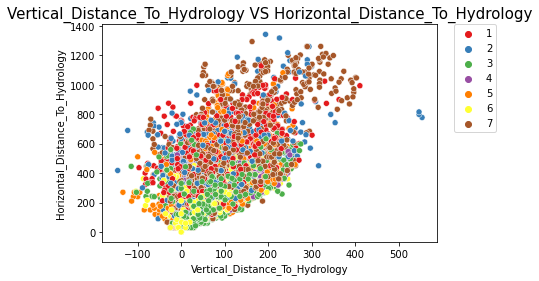

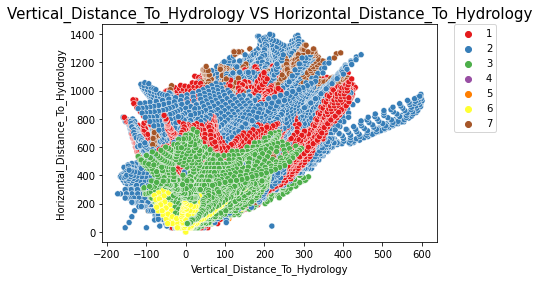

In [9]:
# Visualize some collinear features with Cover_Type

figsize = (20,20)

# plot the first subplot
sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology", 
                hue="Cover_Type", data=train_df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Vertical_Distance_To_Hydrology VS Horizontal_Distance_To_Hydrology", size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

figsize = (20,20)

# Visualize some collinear features with Cover_Type

figsize = (20,20)

# plot the first subplot
sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology", 
                hue="Cover_Type", data=raw_data, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Vertical_Distance_To_Hydrology VS Horizontal_Distance_To_Hydrology", size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

figsize = (20,20)


All cover types show a linear relationship between vertical and horizontal distance to hydrology. The slopes of the cover types do not show any difference though the absolute position is different depending on the cover type. For a given vertical distance to hydrology, as the horizontal distance to hydrology increases the type of cover tends to change. Cover types 1, 2, and 7 are dominant at higher horizontal distance to hydrology while cover types 3 and 6 are dominant at lower horizontal distance to hydrology for a given vertical distance.

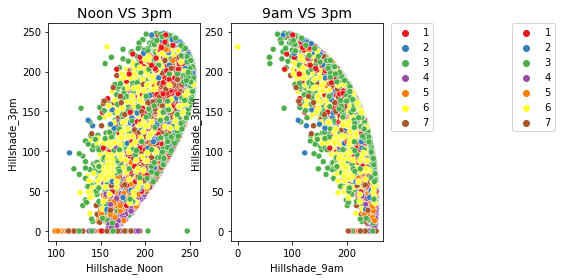

In [10]:
# Visualize hillshade correlations. We pick hillshade 3pm as the representative variable
figsize = (24,20)

# plot the first subplot - noon vs 3pm
plt.subplot(1,2,1)
sns.scatterplot(x="Hillshade_Noon", y="Hillshade_3pm", 
                hue="Cover_Type", data=train_df, 
                hue_norm=(0,8), palette="Set1")
plt.title("Noon VS 3pm", size=14)
plt.legend(bbox_to_anchor=(3.05, 1), loc=2, borderaxespad=0.)

# plot the second subplot - noon vs 9am
plt.subplot(1,2,2)
sns.scatterplot(x="Hillshade_9am", y="Hillshade_3pm", 
                hue="Cover_Type", data=train_df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("9am VS 3pm", size=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In the above plots, we are showing hillshade at 3 pm versus hillshade at noon and 9am. The axis values are proxy for illumination levels. Lower value represents no light and higher value is full brightness. In the noon time, hillshade has a positively increasing slope relationship with hillshade at 3pm. With increasing illumination on the hillshade at noon, the hillshade at 3pm also increases. For hillshade at 9m, there is a negative slope for hillshade at 3pm. When it is brightest at 9am, it shows lowest illumination intensity at the hillshade for 3pm. Based on observation, we can conclude that there are correlations between hillshade at different times and we can use one of the hillshade timing variable as a representation for hillshade as they are all correlated to each other.

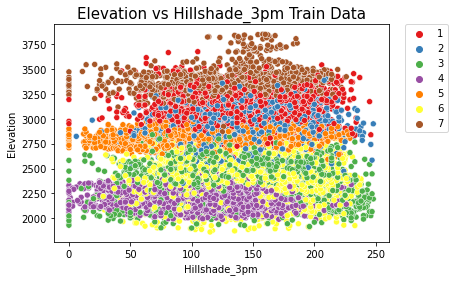

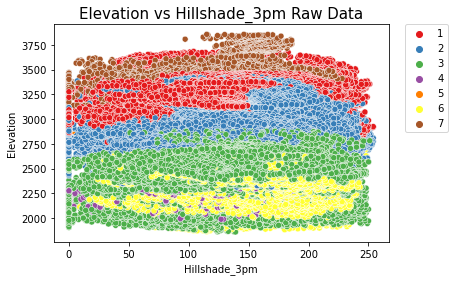

In [11]:
# Visualize some collinear features with Cover_Type

figsize = (20,20)

# plot the first subplot - Elevation vs Hillshade
sns.scatterplot(x="Hillshade_3pm", y="Elevation", 
                hue="Cover_Type", data=train_df,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Elevation vs Hillshade_3pm Train Data", size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

figsize = (20,20)

# plot the first subplot - Elevation vs Hillshade
sns.scatterplot(x="Hillshade_3pm", y="Elevation", 
                hue="Cover_Type", data=raw_data,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Elevation vs Hillshade_3pm Raw Data", size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We have seen from the earlier graphs that elevation has highest impact on cover type. Let us plot elevation vs hillshade at 3pm. Plot above shows the relationship between hillshade_3pm and elevation for different cover types. Cover types are more dependent on the elevation compared to specific hill shade at 3pm. In ascending order of elevation, following cover types can be found.

1. Cover type 4
2. Cover types 3 and 6
3. Cover type 5
4. Cover type 2
5. Cover type 1
6. Cover type 7

From the above we can consider that elevation has a significant impact on the cover type. We can also conclude that the distance to hydrology does have a secondary impact on the cover type.

<a id='Initial_Machine_Learning_Models'></a>
## 2. Initial Machine Learning Models
<a href='#Home'>Click to go Home</a>

Based on the use of ensemble modeling for best performance in real-world settings, we decided to primarily investigate a bagged ensemble model. Bagged ensembles use multiple different models which "vote" on each prediction in order to come to a consensus or find the most likely prediction. An advantage of bagged ensemble models is that the defects of any one single model are hopefully overruled by the votes of the other models, helping to prevent mistaken predictions or overfitting. In order to create a bagged ensemble, several different voting models were created.

These models all used the simplest settings or default parameters. No feature engineering or changes to the training data set were performed prior to this initial stage. Only basic preparation of the provided data was required for the models' use. In addition, with the correct Kaggle test labels from the raw data, full test accuracies may be determined in this notebook without submitting online. 

In [12]:
test_labeled = raw_data[15120:]

test_labeled

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
15120,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,1
15121,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,1
15122,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,1
15123,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,1
15124,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [13]:
# show that this matches the above
test_df

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,...,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,...,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,...,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,...,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565887,581008,2396,153,20,85,17,108,240,237,118,...,0,0,0,0,0,0,0,0,0,0
565888,581009,2391,152,19,67,12,95,240,237,119,...,0,0,0,0,0,0,0,0,0,0
565889,581010,2386,159,17,60,7,90,236,241,130,...,0,0,0,0,0,0,0,0,0,0
565890,581011,2384,170,15,60,5,90,230,245,143,...,0,0,0,0,0,0,0,0,0,0


Having shown that the raw data is ordered and matches the test data when sliced from the correct position, the correct index and test data labels can be formed into a single dataframe for scoring.

In [14]:
# create correct labels df with index
test_labels_correct = pd.DataFrame(data = test_labeled, 
                                   index = test_df.loc[:, "Id"],
                                  columns = ["Cover_Type"])

# overwrite last value from NaN to correct label
test_labels_correct.loc[581012, "Cover_Type"] = 3

# cast back to int
test_labels_correct = test_labels_correct.astype("int32")

test_labels_correct

,Cover_Type
Id,
15121,1
15122,1
15123,1
15124,1
15125,1
...,...
581008,3
581009,3
581010,3


The training data also should be prepared by dropping the ID column and storing the labels separately for training.

In [15]:
# extract labels from training data
train_labels_df = train_df.loc[:, "Cover_Type"]

# extract training data except labels and ID column
train_df = train_df.loc[:, (train_df.columns != "Cover_Type") & 
                        (train_df.columns != "Id")]

train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


With the scoring labels already set aside, the test dataframe can be prepared by similarly dropping the ID column.

In [16]:
# extract indices of testing data for scoring
test_index_df = test_df.loc[:, "Id"]

# extract test data except ID column
test_df = test_df.loc[:, test_df.columns != "Id"]

test_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,0
1,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,0
2,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,0
3,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,0
4,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,0


### 2.1 K-Nearest Neighbors Model

In [17]:
# create model
knn_model = KNeighborsClassifier()

# fit to training data
knn_model.fit(train_df, train_labels_df)

# supply the test_df to knn_model and create predictions
knn_predictions = knn_model.predict(test_df)

# converts predictions from np array to pd dataframe
knn_predictions_df = pd.DataFrame(data = knn_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

In [18]:
knn_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           knn_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*knn_score, 3)) + "%.")

Accuracy is ~63.251%.


### 2.2 Naive-Bayes Model

In [19]:
# create model
nb_model = GaussianNB()

# fit to training data
nb_model.fit(train_df, train_labels_df)

# supply the test_df to GNB_model and create predictions
nb_predictions = nb_model.predict(test_df)

# converts predictions from np array to pd dataframe
nb_predictions_df = pd.DataFrame(data = nb_predictions, 
                                 index = test_index_df, 
                                 columns = ["Cover_Type"])

In [20]:
nb_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           nb_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*nb_score, 3)) + "%.")

Accuracy is ~41.871%.


### 2.3 Logistic Regression Model

In [21]:
# create model
log_model = LogisticRegression()

# fit to training data
log_model.fit(train_df, train_labels_df)

# supply the test_df to log_model and create predictions
log_predictions = log_model.predict(test_df)

# converts predictions from np array to pd dataframe
log_predictions_df = pd.DataFrame(data = log_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

/Users/aidanjackson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
log_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           log_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*log_score, 3)) + "%.")

Accuracy is ~40.021%.


### 2.4 Decision Tree Model

In [23]:
# create model
dt_model = DecisionTreeClassifier()

# fit to training data
dt_model.fit(train_df, train_labels_df)

# supply the test_df to log_model and create predictions
dt_predictions = dt_model.predict(test_df)

# converts predictions from np array to pd dataframe
dt_predictions_df = pd.DataFrame(data = dt_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

In [24]:
dt_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           dt_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*dt_score, 3)) + "%.")

Accuracy is ~66.185%.


### 2.5 Neural Network Model

In [25]:
# create model
nn_model = MLPClassifier()

# fit to training data
nn_model.fit(train_df, train_labels_df)

# supply the test_df to nn_model and create predictions
nn_predictions = nn_model.predict(test_df)

# converts predictions from np array to pd dataframe
nn_predictions_df = pd.DataFrame(data = nn_predictions, 
                                 index = test_index_df, 
                                 columns = ["Cover_Type"])

In [26]:
nn_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           nn_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*nn_score, 3)) + "%.")

Accuracy is ~43.694%.


### Preliminary Model Results

<center>

|Model|Kaggle Accuracy (%)|
|:-----:|:----:|
|KNN| 63 |
|NB| 42 |
|LR| 40 |
|DT| 66 |
|NN| 44 |

</center>

<a id='Feature_Engineering'></a>
## 3. Feature Engineering
Clean and Format the Data

<a href='#Home'>Click to go Home</a>

As observed by the EDA, there are some colinear relationships and some skewed data that formatting and data cleaning could help result in cleaner and better analysis as well as prevent overfitting of our model.

First, the `Soil_Type` and `Wilderness_Area` parameters are difficult to observe in the binary format.  We will transform these to be a categorical parameter and reduce our features from 54 to 12. While it is generally risky and can be incorrect to map a series of binary variables to a numerical scale, certain models are able to handle such a transformation well. The decision tree is an example of one where it works well, while models such as the NN or KNN are examples where it does not. As such, the decision tree model will incorporate all engineered features while the NN and KNN will incorporate only a subset based on what was found to improve them the most.

In [27]:
def convert_soil_types_to_categorical(passed_df):
    '''Maps soil types to single continuous variable
    and returns a copy of the original df.'''
    
    df = passed_df.copy()
    df["SoilType"] = 0
    columns = list(df)

    for col_name in columns:
        soil_type = 0
        if col_name[0:9] == 'Soil_Type':
            soil_type = int(col_name[9:])
            df["SoilType"] = df["SoilType"] + df[col_name]*soil_type
            df = df.drop(columns=[col_name], errors = "ignore")
            
    return df          
            
def convert_wilderness_areas_to_categorical(passed_df):
    '''Maps wilderness areas to a single continuous variable
    and returns a copy of the original df.'''

    df = passed_df.copy()
    df["WildernessArea"] = 0
    columns = list(df)

    for col_name in columns:
        wild_area = 0
        if col_name[0:15] == 'Wilderness_Area':
            wild_area = int(col_name[15:])
            df["WildernessArea"] = df["WildernessArea"] + df[col_name]*wild_area

    for col_name in columns:
        if col_name[0:15] == 'Wilderness_Area':
            df = df.drop(columns=[col_name], errors = "ignore")

    return df

dt_train = convert_soil_types_to_categorical(train_df)
dt_test = convert_soil_types_to_categorical(test_df)

dt_train = convert_wilderness_areas_to_categorical(dt_train)
dt_test = convert_wilderness_areas_to_categorical(dt_test)

dt_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,SoilType,WildernessArea
0,2596,51,3,258,0,510,221,232,148,6279,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,29,1


Now the histograms and correlation of the new features can be observed.

/Users/aidanjackson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aidanjackson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


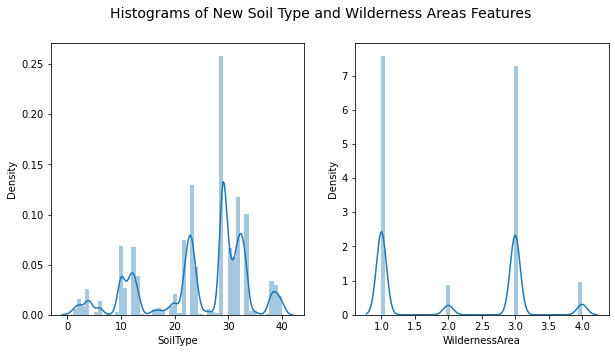

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
continuous_data = dt_test.loc[:,'SoilType':'WildernessArea']

for i, col in enumerate(continuous_data.columns):
    sns.distplot(ax=ax[i],a=continuous_data[col])
    
plt.suptitle('Histograms of New Soil Type and Wilderness Areas Features', fontsize=14)
plt.show()

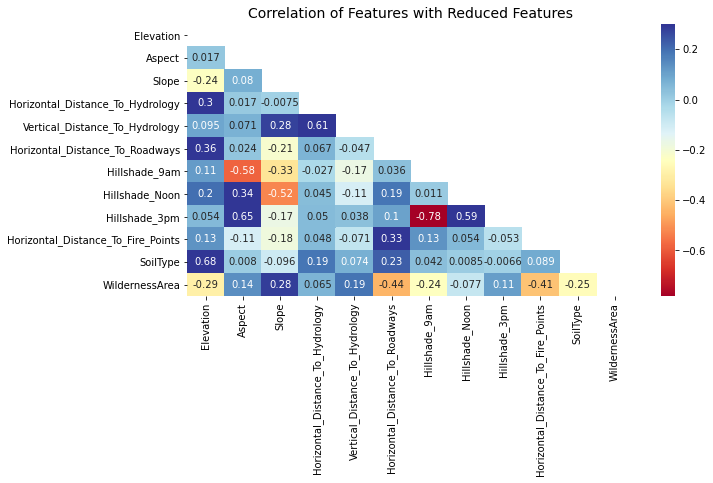

In [29]:
# create dateframe from the test data correlation data
correlations = pd.DataFrame(dt_test.\
                            loc[:,'Elevation':'WildernessArea'].corr())
plt.figure(figsize=(10,5))
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap
sns.heatmap(correlations, vmax=0.3, mask=mask, 
            square=False, linecolor='white', 
            cmap="RdYlBu", annot=True)
plt.title('Correlation of Features with Reduced Features', size=14)
plt.show()

Now it it is easy to see the highest correlated items are the hillshade parameters.  Because hillshade varies throughout the year and is also highly correlated to slop and aspect, these features were averaged into one parameter.

In [30]:
dt_train['Average_Hillshade'] = ((dt_train['Hillshade_9am']**2 +
                                 dt_train['Hillshade_Noon']**2 + 
                                  dt_train['Hillshade_3pm']**2)/3)**0.5

dt_test['Average_Hillshade'] = ((dt_test['Hillshade_9am']**2 +
                                 dt_test['Hillshade_Noon']**2 + 
                                 dt_test['Hillshade_3pm']**2)/3)**0.5

dt_train = dt_train.drop(columns=["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"],
                        errors = "ignore")
dt_test = dt_test.drop(columns=["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"],
                      errors = "ignore")

dt_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,SoilType,WildernessArea,Average_Hillshade
0,2596,51,3,258,0,510,6279,29,1,203.771931
1,2590,56,2,212,-6,390,6225,29,1,205.285168
2,2804,139,9,268,65,3180,6121,12,1,207.866143
3,2785,155,18,242,118,3090,6211,30,1,206.697847
4,2595,45,2,153,-1,391,6172,29,1,204.659066


The next features that are commonly related are the vertical and horizontal distance to hydrology. Here a simple transformation is performed to find the Euclidean distance between the two.

In [31]:
dt_train['Total_Distance_to_Hydrology'] = (dt_train['Horizontal_Distance_To_Hydrology']**2 
                                           + 
                                           dt_train['Vertical_Distance_To_Hydrology']**2)**0.5
dt_test['Total_Distance_to_Hydrology'] = (dt_test['Horizontal_Distance_To_Hydrology']**2 
                                          + 
                                          dt_test['Vertical_Distance_To_Hydrology']**2)**0.5

dt_train = dt_train.drop(columns=["Horizontal_Distance_To_Hydrology", 
                                  "Vertical_Distance_To_Hydrology"],
                         errors = "ignore")
dt_test = dt_test.drop(columns=["Horizontal_Distance_To_Hydrology",
                                "Vertical_Distance_To_Hydrology"],
                      errors = "ignore")

dt_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,SoilType,WildernessArea,Average_Hillshade,Total_Distance_to_Hydrology
0,2596,51,3,510,6279,29,1,203.771931,258.000000
1,2590,56,2,390,6225,29,1,205.285168,212.084889
2,2804,139,9,3180,6121,12,1,207.866143,275.769832
3,2785,155,18,3090,6211,30,1,206.697847,269.235956
4,2595,45,2,391,6172,29,1,204.659066,153.003268


Now we can run a PCA analysis to see which features are causing the most varation and impact to our overall data set.

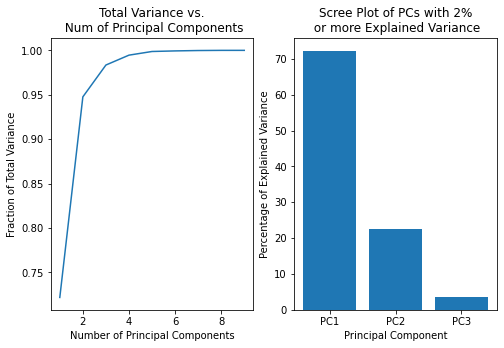

Top 10 features and their loading score influnce on PC1:
--------------------------------------------------------
Horizontal_Distance_To_Roadways       0.812089
Horizontal_Distance_To_Fire_Points    0.555661
Elevation                             0.175173
Horizontal_Distance_To_Hydrology      0.032063
Hillshade_3pm                         0.004386
Hillshade_Noon                        0.003454
Aspect                                0.001864
Slope                                -0.001711
Hillshade_9am                         0.000671
Vertical_Distance_To_Hydrology        0.000439
dtype: float64


In [32]:
def do_pca (t_data, n, k_principal_components):
    # Use PCA from sklearn and set number of components to the shape 
    # of the train_data feature size
    # Fit to the Train Data and get the variance ratio
    pca = PCA(n_components=n)
    pca.fit(t_data)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Find only the prinicpal_components ratios
    total_variance = []
    for k in k_principal_components:
        total_variance_ratio = sum(explained_variance_ratio[0:k])
        total_variance.append(total_variance_ratio)

    #Plot the total variance vs. number of principal components,
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(k_principal_components,total_variance)
    ax.set_ylabel("Fraction of Total Variance")
    ax.set_xlabel("Number of Principal Components")
    ax.set_title("Total Variance vs.\n Num of Principal Components") 

    #The following code constructs the Scree plot
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    per_var = per_var[per_var > 2]
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    ax = fig.add_subplot(1,2,2)
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    ax.set_ylabel('Percentage of Explained Variance')
    ax.set_xlabel('Principal Component')
    ax.set_title('Scree Plot of PCs with 2%\n or more Explained Variance')
    plt.show()

    #########################
    # Determine which feature had the biggest influence on PC1
    #########################
    ## Get the loading scores and sort
    loading_scores = pd.Series(pca.components_[0], index=train_df.columns)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    top_10 = sorted_loading_scores[0:10].index.values
    ## print the gene names and their scores (and +/- sign)
    print("Top 10 features and their loading score influnce on PC1:")
    print("--------------------------------------------------------")
    print(loading_scores[top_10])

    return

do_pca(train_df.to_numpy(), train_df.shape[1], 
       k_principal_components = [1,2,3,4,5,6,7,8,9])

From this set we can see the top 4 features that influnce on the first principal component are all distance measurements.  During the EDA it was observed that most of these are either skewed or do not have a normal distribution.  To improve this, these parameters can be normalized to help the variation.

In [33]:
dt_train['Total_Distance_to_Hydrology'] = ((dt_train['Total_Distance_to_Hydrology'] - 
                                            dt_train['Total_Distance_to_Hydrology'].min()) /
                (dt_train['Total_Distance_to_Hydrology'].max() - 
                 dt_train['Total_Distance_to_Hydrology'].min()))

dt_test['Total_Distance_to_Hydrology'] = ((dt_test['Total_Distance_to_Hydrology'] - 
                                           dt_test['Total_Distance_to_Hydrology'].min()) /
                 (dt_test['Total_Distance_to_Hydrology'].max() - 
                  dt_test['Total_Distance_to_Hydrology'].min()))

dt_train['Roadway_Distance_Normal'] = ((dt_train['Horizontal_Distance_To_Roadways'] - 
                                        dt_train['Horizontal_Distance_To_Roadways'].min()) /
                (dt_train['Horizontal_Distance_To_Roadways'].max() - 
                 dt_train['Horizontal_Distance_To_Roadways'].min()))

dt_test['Roadway_Distance_Normal'] = ((dt_test['Horizontal_Distance_To_Roadways'] - 
                                       dt_test['Horizontal_Distance_To_Roadways'].min()) /
                 (dt_test['Horizontal_Distance_To_Roadways'].max() - 
                  dt_test['Horizontal_Distance_To_Roadways'].min()))

dt_train['Fire_Points_Distance_Normal'] = ((dt_train['Horizontal_Distance_To_Fire_Points'] - 
                                            dt_train['Horizontal_Distance_To_Fire_Points'].min()) /
                (dt_train['Horizontal_Distance_To_Fire_Points'].max() - 
                 dt_train['Horizontal_Distance_To_Fire_Points'].min()))

dt_test['Fire_Points_Distance_Normal'] = ((dt_test['Horizontal_Distance_To_Fire_Points'] - 
                                           dt_test['Horizontal_Distance_To_Fire_Points'].min()) /
                 (dt_test['Horizontal_Distance_To_Fire_Points'].max() - 
                  dt_test['Horizontal_Distance_To_Fire_Points'].min()))

dt_train['Elevation_Normal'] = ((dt_train['Elevation'] - 
                                 dt_train['Elevation'].min()) /
                (dt_train['Elevation'].max() - 
                 dt_train['Elevation'].min()))

dt_test['Elevation_Normal'] = ((dt_test['Elevation'] - 
                                dt_test['Elevation'].min()) /
                 (dt_test['Elevation'].max() - 
                  dt_test['Elevation'].min()))

dt_train = dt_train.drop(columns=["Horizontal_Distance_To_Roadways",
                                 "Horizontal_Distance_To_Fire_Points",
                                 "Elevation"])
dt_test = dt_test.drop(columns=["Horizontal_Distance_To_Roadways",
                               "Horizontal_Distance_To_Fire_Points",
                               "Elevation"])
dt_train.head()

,Aspect,Slope,SoilType,WildernessArea,Average_Hillshade,Total_Distance_to_Hydrology,Roadway_Distance_Normal,Fire_Points_Distance_Normal,Elevation_Normal
0,51,3,29,1,203.771931,0.190134,0.074020,0.897898,0.369084
1,56,2,29,1,205.285168,0.156296,0.056604,0.890176,0.366062
2,139,9,12,1,207.866143,0.203229,0.461538,0.875304,0.473817
3,155,18,30,1,206.697847,0.198414,0.448476,0.888174,0.464250
4,45,2,29,1,204.659066,0.112756,0.056749,0.882597,0.368580


Lastly, `Aspect` has an influence on some of the parameters. Normally, aspect represents the cardinal direction the slope faces, with 0 corresponding to North, 90 to East, 180 to South, and 270 to West. However, geographical sources have found that sometimes only the relative direction between North and South is important for vegetation growth and type.<sup>\[2\]</sup> Therefore, the 360 degree range was mapped to solely a 0 to 180 scale, regardless of whether the slope was also East or West facing. 

In [34]:
dt_train.loc[:, "Aspect"] = abs(dt_train["Aspect"] - 180)
dt_test.loc[:, "Aspect"] = abs(dt_test["Aspect"] - 180)

dt_train.head()

,Aspect,Slope,SoilType,WildernessArea,Average_Hillshade,Total_Distance_to_Hydrology,Roadway_Distance_Normal,Fire_Points_Distance_Normal,Elevation_Normal
0,129,3,29,1,203.771931,0.190134,0.074020,0.897898,0.369084
1,124,2,29,1,205.285168,0.156296,0.056604,0.890176,0.366062
2,41,9,12,1,207.866143,0.203229,0.461538,0.875304,0.473817
3,25,18,30,1,206.697847,0.198414,0.448476,0.888174,0.464250
4,135,2,29,1,204.659066,0.112756,0.056749,0.882597,0.368580


While all the above engineered features were useful for the decision tree model, only a subset was found to improve the accuracy of the NN and KNN models. These are shown below to produce the best individual models for use in the ensemble.

In [35]:
# make deep copy
knn_train = train_df.copy()
knn_test = test_df.copy()

# apply aspect feature engineering
knn_train.loc[:, "Aspect"] = abs(train_df["Aspect"] - 180)
knn_test.loc[:, "Aspect"] = abs(test_df["Aspect"] - 180)

Note that bootstrapping was also employed for the NN model. Because of the large discrepancy between the sizes of the provided training and test data, sampling with replacement was performed on the training set to help prevent overfitting and reduce the impact of outliers. This was only found to be effective for the NN model.

In [36]:
# import original data for bootstrapping
# so that it is unedited
data = pd.read_csv("Data/train.csv")

# shuffles the data by taking a random sample without replacement
# and sampling 100% of the original dataframe
data = data.sample(frac = 1)

# list of output classes to sample for bootstrapping
cover_types = [1, 2, 3, 4, 5, 6, 7]

# relative weights of each class to represent in bootstrapped sample
weights = [4, 5, 1, 1, 1, 1, 1]

# create series to hold the probability weights for each sample
weight_series = pd.Series(range(1, len(train_df)+2))

# loop over each weight and
# assign to appropriate place in series
for weight, cover_type in zip(weights, cover_types):
    
    # assign appropriate weight
    weight_series[data.loc[data.Cover_Type == cover_type]["Id"]] = weight
    

# create bootstrapped data
bootstrapped_data = data.sample(frac = 3, replace = True, 
                                weights = weight_series, random_state = 1)

bootstrapped_data.reset_index(drop = True, inplace = True)

# extract labels from training data
bootstrapped_labels = bootstrapped_data.loc[:, "Cover_Type"]

# extract training data except labels and ID column
bootstrapped_data = bootstrapped_data.loc[:, 
                                          (bootstrapped_data.columns != "Cover_Type") & 
                                          (bootstrapped_data.columns != "Id")]

bootstrapped_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,3008,215,11,696,112,5880,209,251,176,5600,...,0,0,0,0,0,0,0,0,0,0
1,3348,262,11,30,8,2106,192,246,192,2131,...,0,1,0,0,0,0,0,0,0,0
2,2413,308,20,30,7,1253,161,224,201,300,...,0,0,0,0,0,0,0,0,0,0
3,3083,257,4,510,-25,6363,209,242,171,2873,...,0,0,0,0,0,0,0,0,0,0
4,2622,260,12,335,18,1855,191,246,194,696,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45355,2797,85,8,30,4,990,232,227,128,2551,...,0,0,0,0,0,0,0,0,0,0
45356,3008,117,3,30,2,5128,225,236,146,2644,...,0,0,0,0,0,0,0,0,0,0
45357,3130,110,12,421,51,5271,240,227,115,1172,...,0,0,0,0,0,0,0,0,0,0
45358,2750,146,12,390,166,1616,236,238,131,1126,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# create deep copies
nn_train = bootstrapped_data.copy()
nn_test = test_df.copy()

# add total distance and hydro features but dont 
# drop the individual components
nn_train.loc[:, "Total_Distance_to_Hydrology"] = (nn_train['Horizontal_Distance_To_Hydrology']**2 + 
                                           nn_train['Vertical_Distance_To_Hydrology']**2)**0.5

nn_test.loc[:, "Total_Distance_to_Hydrology"] = (nn_test['Horizontal_Distance_To_Hydrology']**2 + 
                                          nn_test['Vertical_Distance_To_Hydrology']**2)**0.5

nn_train.loc[:, "Average_Hillshade"] = abs((nn_train['Hillshade_9am']+
                                            nn_train['Hillshade_Noon']+
                                            nn_train['Hillshade_3pm'])
                                           /3)

nn_test.loc[:, "Average_Hillshade"] = abs((nn_test['Hillshade_9am']+
                                            nn_test['Hillshade_Noon']+
                                            nn_test['Hillshade_3pm'])
                                           /3)

# overwrite aspect feature
nn_train.loc[:, "Aspect"] = abs(nn_train["Aspect"] - 180)
nn_test.loc[:, "Aspect"] = abs(nn_test["Aspect"] - 180)

nn_train

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Total_Distance_to_Hydrology,Average_Hillshade
0,3008,35,11,696,112,5880,209,251,176,5600,...,0,0,0,0,0,0,0,0,704.953899,212.000000
1,3348,82,11,30,8,2106,192,246,192,2131,...,0,0,0,0,0,0,0,0,31.048349,210.000000
2,2413,128,20,30,7,1253,161,224,201,300,...,0,0,0,0,0,0,0,0,30.805844,195.333333
3,3083,77,4,510,-25,6363,209,242,171,2873,...,0,0,0,0,0,0,0,0,510.612377,207.333333
4,2622,80,12,335,18,1855,191,246,194,696,...,0,0,0,0,0,0,0,0,335.483234,210.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45355,2797,95,8,30,4,990,232,227,128,2551,...,0,0,0,0,0,0,0,0,30.265492,195.666667
45356,3008,63,3,30,2,5128,225,236,146,2644,...,0,0,0,0,0,0,0,0,30.066593,202.333333
45357,3130,70,12,421,51,5271,240,227,115,1172,...,0,0,0,0,0,0,0,0,424.077823,194.000000
45358,2750,34,12,390,166,1616,236,238,131,1126,...,0,0,0,0,0,0,0,0,423.858467,201.666667


<a id='Hyperparameter_Tuning'></a>
## 4. Hyperparameter Tuning
<a href='#Home'>Click to go Home</a>

### 4.1 K-Nearest Neighbors Model

Tuned parameters:
* Number of N neighbors tuned to 1 (default)
* Euclidean distance metric used (default)
* Overwrote the Aspect feature

In [38]:
# create model
knn_model = KNeighborsClassifier(n_neighbors = 1, metric = 'euclidean')

# fit to training data
knn_model.fit(knn_train, train_labels_df)

# supply the test_df to knn_model and create predictions
knn_predictions = knn_model.predict(knn_test)

# converts predictions from np array to pd dataframe
knn_predictions_df = pd.DataFrame(data = knn_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

In [39]:
knn_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           knn_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*knn_score, 3)) + "%.")

Accuracy is ~70.543%.


### 4.2 Naive-Bayes Model

Tuned parameters:
* Overwrote the Aspect feature

In [40]:
# create model
nb_model = GaussianNB()

# fit to training data
nb_model.fit(knn_train, train_labels_df)

# supply the test_df to GNB_model and create predictions
nb_predictions = nb_model.predict(knn_test)

# converts predictions from np array to pd dataframe
nb_predictions_df = pd.DataFrame(data = nb_predictions, 
                                 index = test_index_df, 
                                 columns = ["Cover_Type"])

In [41]:
nb_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           nb_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*nb_score, 3)) + "%.")

Accuracy is ~41.931%.


### 4.3 Logistic Regression Model

Tuned parameters:
* Added Weighting to Account for Test Data populations
* Removed outliers from the two man made categories - 'Horizontal_Distance_To_Fire_Points' and 'Horizontal_Distance_To_Roadways'
* Penalty function variable set to C = 39.4421
* Used L1 penalty function
* Used Liblinear solver
* Switched multi-class to auto

In [42]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [43]:
# Add Weighting to Account for Test Data populations
weights = np.bincount(log_predictions)[1:] / log_predictions.shape[0]
weights = dict(enumerate(weights.flatten(), 1))

# Let's remove outliers from Distance to Fire Points
RFE = ['Horizontal_Distance_To_Fire_Points']

ftr_train_df = train_df.copy()
ftr_train_labels_df = train_labels_df.copy()

for column in RFE:
    # Drop Values below 1Q
    indexNames = ftr_train_df[ftr_train_df[column] < 
                      outlier_function(ftr_train_df, column)[0]].index
    ftr_train_df = ftr_train_df.drop(indexNames)
    ftr_train_labels_df = ftr_train_labels_df.drop(indexNames)
    
    # Drop Values above 3Q
    indexNames = ftr_train_df[ftr_train_df[column] > 
                      outlier_function(ftr_train_df, column)[1]].index
    ftr_train_df = ftr_train_df.drop(indexNames)
    ftr_train_labels_df = ftr_train_labels_df.drop(indexNames)

# create model
log_model = LogisticRegression(C=39.4421, 
                               penalty = 'l1', 
                               solver = "liblinear",
                               class_weight = weights,
                               multi_class = "auto")  


# fit to training data
log_model.fit(ftr_train_df, ftr_train_labels_df)

# supply the test_df to log_model and create predictions
log_predictions = log_model.predict(knn_test)

# converts predictions from np array to pd dataframe
log_predictions_df = pd.DataFrame(data = log_predictions, 
                                  index = test_index_df, 
                                  columns = ["Cover_Type"])

In [44]:
log_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           log_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*log_score, 3)) + "%.")

Accuracy is ~59.267%.


### 4.4 Decision Tree Model

Tuned parameters:
* Switched to ExtraTreesClassifier
* Used 1000 estimators
* Included all engineered features

In [45]:
dt_model = ExtraTreesClassifier(random_state=0, n_estimators = 1000)

dt_model.fit(dt_train, train_labels_df)

dt_predictions = dt_model.predict(dt_test)

dt_predictions_df = pd.DataFrame(data = dt_predictions, 
                                 index = test_index_df, 
                                 columns = ["Cover_Type"])

In [46]:
dt_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           dt_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*dt_score, 3)) + "%.")

Accuracy is ~76.892%.


### 4.5 Neural Network Model

Tuned parameters:
* Used 9 hidden layers, 100 nodes each
* Included early stopping
* Used relu activation function
* Used alpha of 0.0001 (default)
* Included two engineered features, total distance to waterways and aspect

In [47]:
# number and structure of hidden layers
hidden_layer_sizes = tuple([100]*9)

# create model
nn_model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, 
                           early_stopping = True, alpha = 0.0001, 
                           activation = "relu", random_state = 1)

# fit to training data
nn_model.fit(nn_train, bootstrapped_labels)

# supply the test_df to nn_model and create predictions
nn_predictions = nn_model.predict(nn_test)

# converts predictions from np array to pd dataframe
nn_predictions_df = pd.DataFrame(data = nn_predictions, 
                                 index = test_index_df, 
                                 columns = ["Cover_Type"])

In [48]:
nn_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           nn_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*nn_score, 3)) + "%.")

Accuracy is ~69.57%.


### Tuned & Featured Engineered Model Results

<center>

|Model|Kaggle Accuracy, Before (%)|Kaggle Accuracy, After (%)|
|:-----:|:----:|:----:|
|KNN| 63 | 71 |
|NB| 42 | 42 |
|LR| 40 | 59 |
|DT| 66 | 77 |
|NN| 44 | 71 |

</center>

<a id='Evaluation_of_the_Best_Model'></a>
## 5. Evaluation of the Best Model
<a href='#Home'>Click to go Home</a>

With the hyperparameters tuned and features optimized for each individual model, different groupings and voting schemes were examined for those which produced the best bagged ensemble predictions. 

Shown below, the best voting scheme was determined to be the Decision Tree voting twice with the KNN and Neural Network each voting once. Because the Decision Tree had the single highest accuracy of any model, this scheme allows the default prediction to be that of the decision tree when all three models differ in their predictions. If the KNN and Neural Network models agree on a prediction that the DT disagrees with, then the Scipy mode function automatically selects the cover type with the lower number by virtue of its internal functionality. That is, if the KNN/NN models predict a cover type 1 while the DT predicts a cover type 7, then cover type 1 is chosen as the final prediction. This is beneficial as it involves the naive observation that cover types 1 and 2 make up ~85% of the total test data. If the scope of this model was to be expanded to include other Colorado forests that did not match this trend, then the robustness of the model may not hold up.

In [49]:
# define the voting scheme
model_predictions_list = [knn_predictions_df, dt_predictions_df,
                          dt_predictions_df, nn_predictions_df]

# create copy of a test prediction df to overwrite
# by default it is a deep copy
final_predictions_df = nn_predictions_df.copy()

# loop over each test point
for i in range(len(final_predictions_df)):
    
    # list to hold each prediction for the current test point from each model
    current_predictions = [current_preds.iloc[i][0] for current_preds in model_predictions_list]
    
    # finds most popular current prediction
    best_prediction = mode(current_predictions)

    # write best prediction to final df
    final_predictions_df.iloc[i][0] = best_prediction[0][0]

In [50]:
ensemble_score = accuracy_score(test_labels_correct["Cover_Type"].to_numpy(), 
                           final_predictions_df["Cover_Type"].to_numpy())

print("Accuracy is ~" + str(np.round(100*ensemble_score, 3)) + "%.")

Accuracy is ~77.779%.


### Final Ensemble Kaggle Accuracy: 78.025%
### Best Ensemble Kaggle Accuracy: 78.814%
### Best Leaderboard Position: 297 / 1693

The final ensemble is found to have an accuracy just over 78%. Other times, likely due to random variation or random states, the best accuracy was found to be just under 79%. With the best accuracy recorded from Kaggle being 78.814%, the final leaderboard position would have been 297 out of 1693 had this team entered.

<a id='Interpret_Model_Results'></a>
## 6. Interpret Model Results
<a href='#Home'>Click to go Home</a>

In [51]:
# generate and print classification report
print(classification_report(test_labels_correct, final_predictions_df))

np.set_printoptions(precision=2)

              precision    recall  f1-score   support

           1       0.76      0.83      0.80    209679
           2       0.89      0.70      0.79    281141
           3       0.77      0.89      0.83     33595
           4       0.18      0.66      0.28       587
           5       0.27      0.94      0.42      7333
           6       0.60      0.86      0.71     15207
           7       0.68      0.94      0.79     18350

    accuracy                           0.78    565892
   macro avg       0.59      0.83      0.66    565892
weighted avg       0.81      0.78      0.78    565892



Shown above, the classification report shows that the ensemble model was most precise with the second cover type. The first and third cover types also had high precision >75%, which, combined with the second cover type, accounted for ~90% of the data. The fourth and fifth cover types had particularly low precision being <20%. While the lowest, accuracy may not be as strongly affected by these misclassifications as they made up such a low portion of the data.

Notably, the recall for the second cover type was less than that of the first or third cover types. This suggests that perhaps the model is too conservative with the second cover type, where it doesn't correctly identify enough true examples while also not identifying many false examples. The opposite trend is found for the first cover type, where the recall is greater than the precision. This suggests that the ensemble is more generous with what it predicts as the first cover type, with a greater number of incorrect examples assigned to it while also finding a larger fraction of the correct examples.

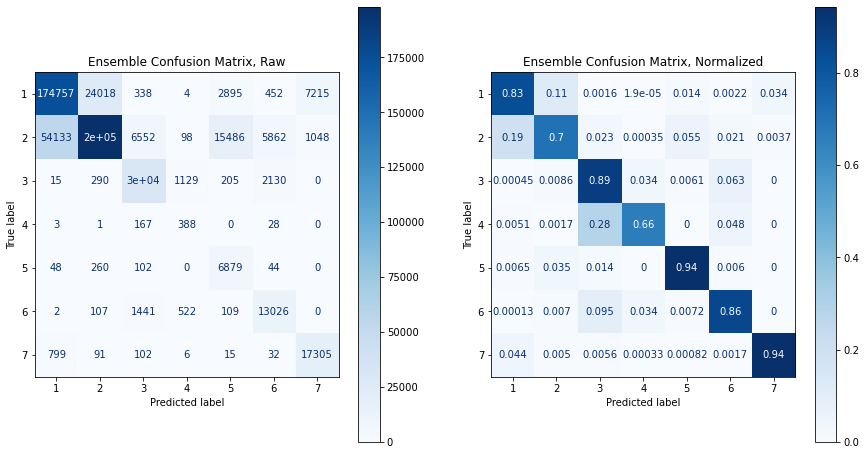

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))

cm = confusion_matrix(test_labels_correct, final_predictions_df)
cm_norm = confusion_matrix(test_labels_correct, final_predictions_df, 
                           normalize = "true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = [str(number) for number in range(1, 8)])
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                              display_labels = [str(number) for number in range(1, 8)])


disp = disp.plot(include_values = True, cmap = "Blues", 
                 ax = axes.flatten()[0], xticks_rotation= "horizontal")
disp_norm = disp_norm.plot(include_values = True, cmap = "Blues", 
                 ax = axes.flatten()[1], xticks_rotation= "horizontal")

disp.ax_.set_title("Ensemble Confusion Matrix, Raw")
disp_norm.ax_.set_title("Ensemble Confusion Matrix, Normalized")

plt.show()

The ensemble confusion matrices are shown above. Once normalized, they demonstrate that the most accurately predicted cover types overall were the fifth and seventh. Because very few of the data were from these classes, however, the overall accuracy was much closer to that which was observed for the first and second cover types. 

As can be seen in the raw confusion matrix, more true examples from cover type two were mistaken as cover type one than there were examples of any later cover type in the testing data set. Thus, to have the greatest improvement of accuracy, it would be more worthwhile if the model could differentiate better between the first two cover types than identify any of the others that come later. In fact, if this design goal was chosen from the start, a model perfectly capable of determining whether an example was more likely to be cover type one versus cover type two would have had an accuracy of ~85%, higher than that which was recorded for this ensemble model. This was also have been a top 20 score on the leaderboard overall, showing it was either not intuitive or difficult to achieve. In the spirit of following the broader goal of the competition, however, at being able to be of use for forest rangers encountering any cover type, a model not following such a naive path would be preferred.

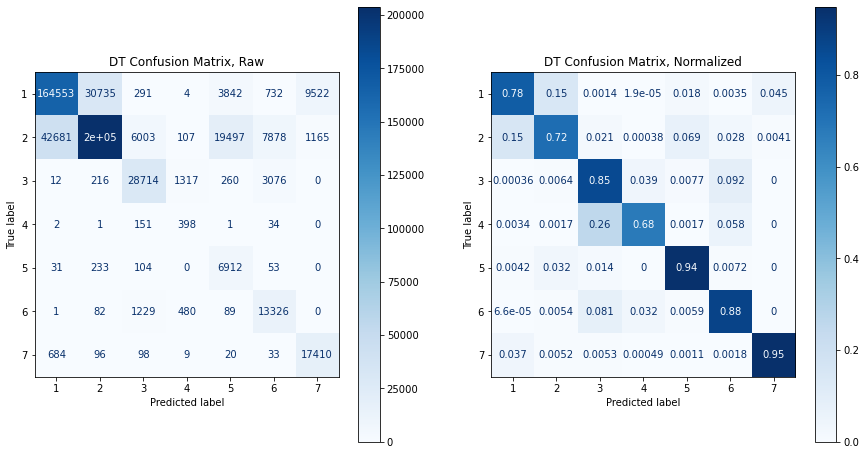

In [53]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))

# confusion matrices options
titles_options = [("DT Confusion Matrix, Raw", None, axes.flatten()[0]),
              ("DT Confusion Matrix, Normalized", 'true', axes.flatten()[1])]

for title, normalize, axis in titles_options:
    disp = plot_confusion_matrix(dt_model, dt_test, test_labels_correct,
                                 display_labels= [str(number) for number in range(1, 8)],
                                 cmap=plt.cm.Blues,
                                 ax = axis,
                                 normalize = normalize)
    disp.ax_.set_title(title)

plt.show()

To better understand the causes of performance of the ensemble model, the confusion matrices of each component model feeding into it can also be examined. The two confusion matrices above demonstrate the results of the best decision tree model, which contributes the most to the ensemble by voting twice. Similar to what was observed overall, the model is most accurate with the fifth and seventh cover types. Also because these make up such a small portion of the overall data, however, the final accuracy is closer to that found for cover types one or two. The single lowest accuracy was found for cover type four, which was mistaken for cover type three 26% of the time. While this was the single greatest case of mistaken identity, improvements to this would likely not affect the final accuracy much due to the low number of overall cases shown in the raw matrix. As cover types one and two were dominating and also mistaken for eachother 15% of the time each, improving these cases would result in a better decision tree and ensemble overall.

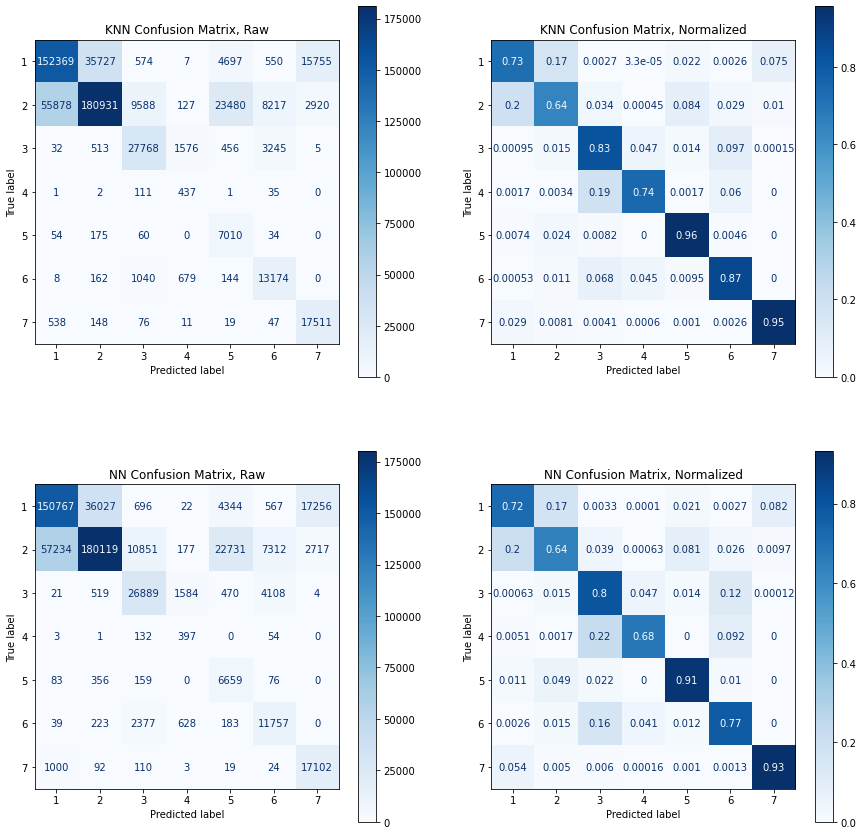

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))

# options for confusion matrices
titles_options = [("KNN Confusion Matrix, Raw", 
                   None, knn_model, knn_test, axes.flatten()[0]),
                  ("KNN Confusion Matrix, Normalized", 'true', 
               knn_model, knn_test, axes.flatten()[1]), 
                  ("NN Confusion Matrix, Raw", None, 
                   nn_model, nn_test, axes.flatten()[2]),
                  ("NN Confusion Matrix, Normalized", "true", 
                   nn_model, nn_test, axes.flatten()[3])]

for title, normalize, model, data, axis in titles_options:
    disp = plot_confusion_matrix(model, data, test_labels_correct,
                                 display_labels= [str(number) for number in range(1, 8)],
                                 cmap=plt.cm.Blues,
                                 ax = axis,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

Comparing the confusion matrices of the KNN and NN models, which also vote along with the DT in the ensemble, reveal similar trends. For example, the fifth and seventh cover types are the most accurately predicted across all three models. Instead of an equal number of mistaken predictions between the first and second cover types in each direction, the KNN and NN models both much more often mistook the first cover type for the second than the reverse. This was not observed in the DT model, which mistook the first two cover types for each other about equally and likely contributed to its higher score. Because the KNN and NN models agree with each other in this way, and because of the naive way in which tie votes are given to the lower cover type, this likely created a significant number of inaccurate predictions in the ensemble. If one more model could be trained with a better focus solely at differentiating between these first two cover types, it could be included to break these ties while the larger ensemble still had the advantage of better predicting the less frequently encountered cover types. 

<a id='Summary_Conclusions'></a>
## 7. Summary & Conclusions
<a href='#Home'>Click to go Home</a>

As expected, the ensemble model was able to perform better than any single model that had been developed. This fit expectations that ensemble models are able to take advantage of a group concensus while ignoring individual model defects that may sometimes result in incorrect predictions. Based on what was found in the Section 6, the greatest number of incorrect predictions resulted from mistaking cover types one and two for one another. Most of the the time this resulted from the NN and KNN models together incorrectly predicting cover type two for cover type one cases, tying the DT model. Since the tie breaking rule assigns the prediction to the lower cover type, and because these make up 85% of the testing dataset, they significantly impact accuracy. If a fourth model was included that was designed specifically to differentiate between the first two cover types, it could serve as a tie breaking and significantly improve accuracy. Such a naive model perfectly capable of differentiating between these two on its own would have one of the highest scores recorded in the competition at ~85%, but included with the ensemble this accuracy would be higher. This again would come from the group consensus taking ability of the ensemble model, which would utilize the cover type one/two differentiator in cases of a tie but would have little impact from it in other cases. Thus, such an improved ensemble would still be able to accurately predict cover types three through seven, which a model focused solely one types one/two could not do.

Depending on the use case of any model, the dataset may need to be expanded in order to have practical results. All data points currently come from four wilderness areas in certain Colorado national forests, but it is unknown how the areas sampled for the data relate to the rest of the forest it would be used for. As noted, the first two cover types dominate the dataset. This might not be true, however, of the rest of the areas where the model may be used. For example, it could be just that these two cover types were dominate in the area sampled by researchers when creating the dataset. The researchers might also have been studying the forest for some other purpose, which would bias the areas that are observed. Thus, before the model could be implemented while expecting useful results, the data collection process should be verified to be fitting for this task. In additio, other variables, such as temperature or solar flux, would also likely be important to cover type but were not recorded. If this model was used in an area where these omitted variables were different, it would be biased and produce inaccurate results. 

<a id='References'></a>
## 8. References
<a href='#Home'>Click to go Home</a>

\[1\] Franklin, Jennifer A, et. al. (2017). "The Forestry Reclaimation Approach: Guide to Successful Reforestation of Mined Lands." US Forest Service: Northern Research Station. DOI:10.2737/NRS-GTR-169

\[2\] Bennie, Jonathan; Mark O. Hill; Robert Baxter; Brian Huntley (2006). "Influence of slope and aspect on long-term vegetation change in British chalk grasslands". Journal of Ecology. 94 (2): 355–368. doi:10.1111/j.1365-2745.2006.01104.x